In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tnrange
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib as mpl
import scipy

In [2]:
comb_pred = np.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_l20_h40_0.2ms_test.npy").reshape((20,-1))
whole_pred = np.load("/scratch/yjk27/CA1_clust4-60_AP/whole_pred/gru_l20_h40_0.2ms_test.npy").reshape((20,-1))
spk = np.load("/scratch/yjk27/CA1_clust4-60_AP/data/spike_train_0.2ms.npy")[980*50000:].reshape((20,-1))

pred_beniag = np.load("/scratch/yjk27/CA1_clust4-60_AP/y_spikes_hat.npy")
spk_beniag = np.load("/scratch/yjk27/CA1_clust4-60_AP/y_spikes_GT.npy")

fpr_comb_pred, tpr_comb_pred, _ = roc_curve(spk.flatten(), comb_pred.flatten())
fpr_whole_pred, tpr_whole_pred, _ = roc_curve(spk.flatten(), whole_pred.flatten())
fpr_beniag, tpr_beniag, _ = roc_curve(spk_beniag.flatten(), pred_beniag.flatten())
beniag_idx = np.where(np.sum(spk_beniag,1) > 0)[0]

rocarea_comb_pred = roc_auc_score(spk.flatten(), comb_pred.flatten())
rocarea_whole_pred = roc_auc_score(spk.flatten(), whole_pred.flatten())

rocarea_array = np.zeros((20,2))
beniag_array = np.zeros((beniag_idx.shape[0]))

for i in tnrange(20):
    rocarea_array[i,0] = roc_auc_score(spk[i], comb_pred[i])
    rocarea_array[i,1] = roc_auc_score(spk[i], whole_pred[i])
for i in tnrange(beniag_idx.shape[0]):
    beniag_array[i] = roc_auc_score(spk_beniag[beniag_idx[i]], pred_beniag[beniag_idx[i]])

#beniag thresh = 0.1
#comb_pred thresh = 0.04
#whole_pred thresh = 0.04
spk_idx = np.where(spk.flatten() > 0)[0]
beniag_spk_idx = np.where(spk_beniag.flatten() > 0)[0]
comb_pred_corr = np.zeros((200))
whole_pred_corr = np.zeros((200))
beniag_corr = np.zeros((40))

comb_pred_thresh = np.zeros((comb_pred.flatten().size))
whole_pred_thresh = np.zeros((whole_pred.flatten().size))
beniag_thresh = np.zeros((spk_beniag.flatten().size))

comb_pos_idx = np.where(comb_pred.flatten() >= 0.04)[0]
whole_pos_idx = np.where(whole_pred.flatten() >= 0.04)[0]
beniag_pos_idx = np.where(pred_beniag.flatten() >= 0.1)[0]

comb_pred_thresh[comb_pos_idx] = 1
whole_pred_thresh[whole_pos_idx] = 1
beniag_thresh[beniag_pos_idx] = 1

for i in range(spk_idx.size):
    t = spk_idx[i]
    comb_pred_corr += comb_pred_thresh[t-100:t+100]
    whole_pred_corr += whole_pred_thresh[t-100:t+100]
for i in range(beniag_spk_idx.size):
    t = beniag_spk_idx[i]
    beniag_corr += beniag_thresh[t-20:t+20]

<ipython-input-2-8e64ca2e74db>:19: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(20):


  0%|          | 0/20 [00:00<?, ?it/s]

<ipython-input-2-8e64ca2e74db>:22: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(beniag_idx.shape[0]):


  0%|          | 0/420 [00:00<?, ?it/s]

<ipython-input-3-1f86ab4146f1>:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


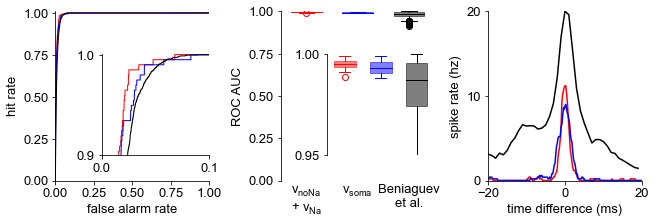

In [3]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = '13'

fig = plt.figure(constrained_layout=True, figsize = (9,3))
gs = fig.add_gridspec(1,3, wspace=0.1, hspace=0.1)
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[0])
ax3 = fig.add_subplot(gs[2])

color1 = "red"
color2 = "blue"
color3 = "black"

colors = [color1, color2, color3]

bp1 = ax1.boxplot(rocarea_array[:,0], positions=[1], widths = 0.6, patch_artist=True)
bp2 = ax1.boxplot(rocarea_array[:,1], positions=[2], widths = 0.6, patch_artist=True)
bp3 = ax1.boxplot(beniag_array, positions=[3], widths = 0.6, patch_artist=True)
bp_list = [bp1, bp2, bp3]

for i in range(3):
    plt.setp(bp_list[i]['boxes'], facecolor=colors[i])
    plt.setp(bp_list[i]['boxes'], alpha=0.5)
    plt.setp(bp_list[i]["fliers"], markeredgecolor=colors[i])
    plt.setp(bp_list[i]["boxes"], color=colors[i])
    plt.setp(bp_list[i]["medians"], color=colors[i])
    for j in range(2):
        plt.setp(bp_list[i]['whiskers'][j], color=colors[i])
        plt.setp(bp_list[i]['caps'][j], color=colors[i])

ax1.set_xticklabels(["$\mathregular{v_{noNa}}$\n+ $\mathregular{v_{Na}}$",
                     "$\mathregular{v_{soma}}$", "Beniaguev\net al."], rotation=0)
ax1.set_ylabel("ROC AUC")
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.set_ylim(0,1)
ax1.tick_params(axis="x", length=0)
ax1.set_yticks(np.arange(0,1.01,0.25))

ins = ax1.inset_axes([0.3,0.15,0.7,0.6])
bp1 = ins.boxplot(rocarea_array[:,0], positions=[1], widths = 0.6, patch_artist=True)
bp2 = ins.boxplot(rocarea_array[:,1], positions=[2], widths = 0.6, patch_artist=True)
bp3 = ins.boxplot(beniag_array, positions=[3], widths = 0.6, patch_artist=True)
bp_list = [bp1, bp2, bp3]

for i in range(3):
    plt.setp(bp_list[i]['boxes'], facecolor=colors[i])
    plt.setp(bp_list[i]['boxes'], alpha=0.5)
    plt.setp(bp_list[i]["fliers"], markeredgecolor=colors[i])
    plt.setp(bp_list[i]["boxes"], color=colors[i])
    plt.setp(bp_list[i]["medians"], color=colors[i])
    for j in range(2):
        plt.setp(bp_list[i]['whiskers'][j], color=colors[i])
        plt.setp(bp_list[i]['caps'][j], color=colors[i])

ins.spines["right"].set_visible(False)
ins.spines["top"].set_visible(False)
ins.spines["bottom"].set_visible(False)
ins.set_ylim(0.95,1)
ins.tick_params(axis="x", length=0)
ins.set_xticks([])
ins.set_yticks(np.arange(0.95,1.001,0.05))

ax2.plot(fpr_comb_pred, tpr_comb_pred, linewidth=1, color=color1)
ax2.plot(fpr_whole_pred, tpr_whole_pred, linewidth=1, color=color2)
ax2.plot(fpr_beniag, tpr_beniag, linewidth=1, color=color3)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.set_ylim(0,1.01)
ax2.set_xlim(0,1)
ax2.set_xlabel("false alarm rate")
ax2.set_ylabel("hit rate")
ax2.set_xticks(np.arange(0,1.01,0.25))
ax2.set_yticks(np.arange(0,1.01,0.25))

ins = ax2.inset_axes([0.3,0.15,0.7,0.6])
ins.plot(fpr_comb_pred, tpr_comb_pred, linewidth=1, color=color1)
ins.plot(fpr_whole_pred, tpr_whole_pred, linewidth=1, color=color2)
ins.plot(fpr_beniag, tpr_beniag, linewidth=1, color=color3)
ins.spines["right"].set_visible(False)
ins.spines["top"].set_visible(False)
ins.set_ylim(0.9,1.001)
ins.set_xlim(0,0.1)
ins.set_xticks([0,0.1])
ins.set_yticks([0.9,1])
#ax2.annotate("p = 0.00171", (0.4,0.85))

ax3.plot(np.arange(-20,20,1), beniag_corr/25, color="black")
ax3.plot(np.arange(-20,20,0.2), comb_pred_corr/5, color="red")
ax3.plot(np.arange(-20,20,0.2), whole_pred_corr/5, color="blue")
ax3.spines["right"].set_visible(False)
ax3.spines["top"].set_visible(False)
ax3.set_ylim(0.9,1.001)
ax3.set_xlim(0,0.1)
ax3.set_xticks([-20,0,20])
ax3.set_yticks([0,10,20])
ax3.set_xlabel("time difference (ms)")
ax3.set_ylabel("spike rate (hz)")

fig.tight_layout()
plt.show()
#fig.savefig("/home/sklee/dendrite/fig_ap/fig_ap_raw.pdf", bbox_inches="tight", transparent=True)